# Setup

In [ ]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from sklearn.manifold import TSNE
import numpy as np

from torch_geometric.utils import to_networkx, degree

from torch_geometric.datasets import Planetoid
import torch, matplotlib.pyplot as plt


# Download the Cora dataset
DS = Planetoid(root="data/Cora", name="Cora")
data = DS[0]
print(data) # x, edge_index, y, train_mask, val_mask, test_mask

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# EDA

Nodes: 2708, Edges: 10556
Features: (2708, 1433), Labels: 7 classes
Masks: {'train_mask': 140, 'val_mask': 500, 'test_mask': 1000}
Avg degree: 3.90, Median: 3.00, Max: 168


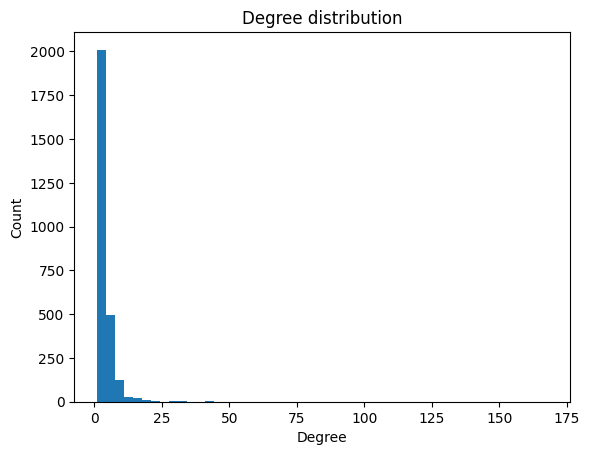

Connected components: 78, LCC size: 2485 (91.8% of nodes)
Average clustering coefficient: 0.241
Class counts: Counter({3: 818, 4: 426, 2: 418, 0: 351, 5: 298, 1: 217, 6: 180})


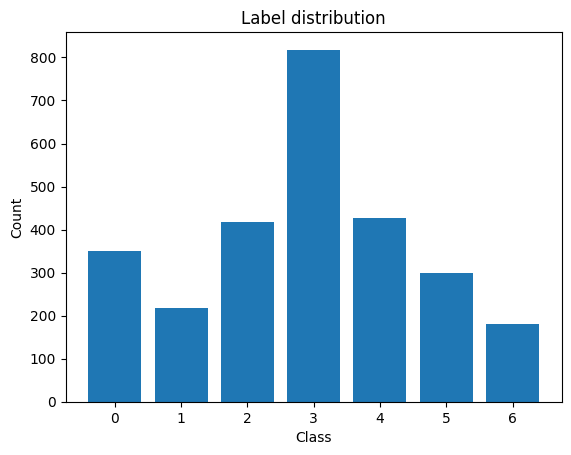

Feature sparsity: 98.73% (non‑zeros: 49216)
Edge homophily (same-label fraction): 0.810
Assortativity by label: 0.771


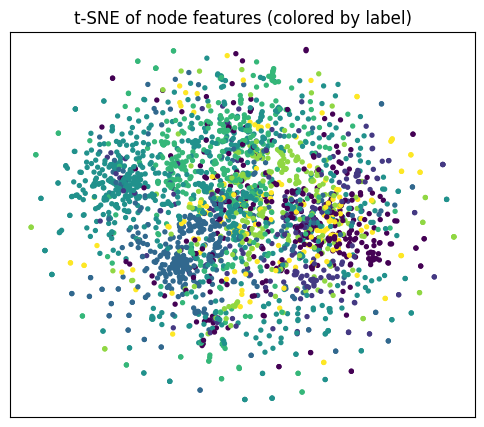

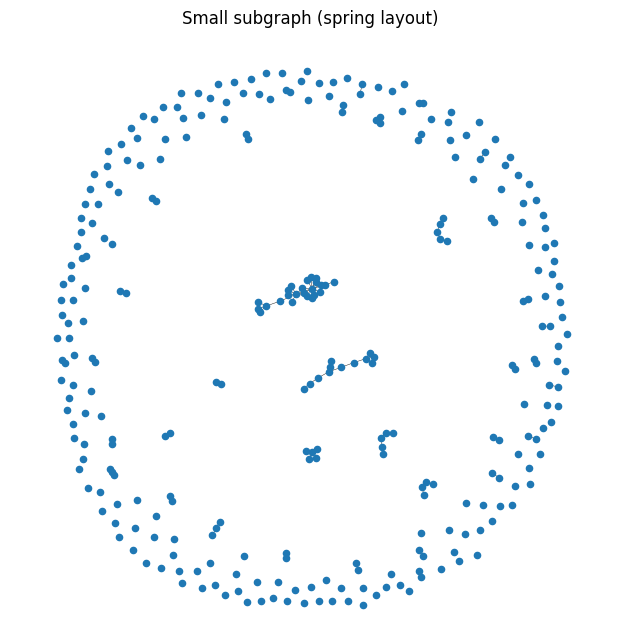

In [29]:
# ---- 0) Dimensions and Masks ----
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")
print(f"Features: {tuple(data.x.shape)}, Labels: {int(data.y.max().item()+1)} classes")
print("Masks:", {k: int(getattr(data, k).sum()) for k in ["train_mask","val_mask","test_mask"]})

# ---- 1) Degree stats
deg = degree(data.edge_index[0], num_nodes=data.num_nodes).cpu().numpy()
print(f"Avg degree: {deg.mean():.2f}, Median: {float(np.median(deg)):.2f}, Max: {deg.max():.0f}")

plt.figure()
plt.hist(deg, bins=50)
plt.xlabel("Degree"); plt.ylabel("Count"); plt.title("Degree distribution")
plt.show()

# ---- 2) Connectivity / clustering (use NetworkX)
G = to_networkx(data, to_undirected=True)   # Cora is treated undirected in most papers
ccs = list(nx.connected_components(G))   # groups of nodes where every node is reachable from every other
lcc = max(ccs, key=len)   # Gets the largest connected component (LCC) by number of nodes.
print(f"Connected components: {len(ccs)}, LCC size: {len(lcc)} ({len(lcc)/data.num_nodes:.1%} of nodes)")

avg_clust = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clust:.3f}")

# ---- 3) Labels
y = data.y.cpu()
counts = Counter(y.tolist())
print("Class counts:", counts)
plt.figure()
plt.bar(range(len(counts)), [counts[i] for i in range(len(counts))])
plt.xlabel("Class"); plt.ylabel("Count"); plt.title("Label distribution")
plt.show()


# ---- 4) Feature sparsity / density
X = data.x
nnz = int((X != 0).sum())
sparsity = 1 - nnz / (X.size(0) * X.size(1))
print(f"Feature sparsity: {sparsity:.2%} (non‑zeros: {nnz})")


# ---- 5) Homophily (fraction of edges that connect same label)
src, dst = data.edge_index
same = (y[src] == y[dst]).float().mean().item()
print(f"Edge homophily (same-label fraction): {same:.3f}")

# ---- 6) Assortativity by label (NetworkX)
# the tendency of nodes to connect to similar nodes with respect to some attribute.
# attach label attribute
nx.set_node_attributes(G, {i:int(y[i]) for i in range(data.num_nodes)}, name="label")
try:
    assort = nx.attribute_assortativity_coefficient(G, "label")
    print(f"Assortativity by label: {assort:.3f}")
except Exception as e:
    print("Assortativity not computed:", e)

# ---- 7) 2D view of features (t-SNE) colored by label
emb = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(X.cpu().numpy())

plt.figure(figsize=(6,5))
plt.scatter(emb[:,0], emb[:,1], c=y.cpu().numpy(), s=8)
plt.title("t-SNE of node features (colored by label)")
plt.xticks([]); plt.yticks([])
plt.show()

# ---- 8) Small subgraph visualization (optional)
sub_nodes = list(lcc)[:300]  # draw a small slice
H = G.subgraph(sub_nodes).copy()
plt.figure(figsize=(6,6))
pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos=pos, node_size=20, width=0.3)
plt.title("Small subgraph (spring layout)")
plt.show()

# Baseline models

| Model                | Val Accuracy | Test Accuracy |
|-----------------------|--------------|---------------|
| Logistic Regression   | .552         |  .576         |
| One-layer MLP         | .574         | .581          |
| SVM                   | .598         | .614          |
| RF                    | .594         | .602          |
| GBM                   | .208         | .202          |


## Logistic regression

In [32]:
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Features and labels
X = data.x.cpu().numpy()    # node features
y = data.y.cpu().numpy()    # labels

# Masks (PyG gives boolean masks for splits)
train_mask = data.train_mask.cpu().numpy()
val_mask = data.val_mask.cpu().numpy()
test_mask = data.test_mask.cpu().numpy()

# Train logistic regression
clf = LogisticRegression(max_iter=500, solver="lbfgs")
clf.fit(X[train_mask], y[train_mask])

# Evaluate
y_val_pred = clf.predict(X[val_mask])
y_test_pred = clf.predict(X[test_mask])

print("Train accuracy:", accuracy_score(y[train_mask], clf.predict(X[train_mask])))
print("Validation accuracy:", accuracy_score(y[val_mask], y_val_pred))
print("Test accuracy:", accuracy_score(y[test_mask], y_test_pred))


Train accuracy: 1.0
Validation accuracy: 0.522
Test accuracy: 0.576


## Feature only MLP

In [33]:
# MLP on Cora (features only) — Apple Silicon ready (MPS)
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device: prefer MPS on Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

# Move data to device
data = data.to(device)  # from your Planetoid loader
X, y = data.x, data.y
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

# (MPS tip) Ensure float32 for stable matmul
X = X.to(torch.float32)

class MLP(nn.Module):
    def __init__(self, in_dim, hid=128, out_dim=None, pdrop=0.5):
        super().__init__()
        out_dim = int(y.max().item()) + 1 if out_dim is None else out_dim
        self.fc1 = nn.Linear(in_dim, hid)
        self.fc2 = nn.Linear(hid, out_dim)
        self.pdrop = pdrop

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.pdrop, training=self.training)
        return self.fc2(x)  # logits

torch.manual_seed(422)
model = MLP(X.size(1), hid=128, pdrop=0.5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

def accuracy(logits, labels):
    return (logits.argmax(dim=1) == labels).float().mean().item()

best_val, best_state = 0.0, None
for epoch in range(1, 501):
    model.train()
    opt.zero_grad(set_to_none=True)
    logits = model(X)
    loss = loss_fn(logits[train_mask], y[train_mask])
    loss.backward()
    opt.step()

    # Eval on-val
    model.eval()
    with torch.no_grad():
        val_acc = accuracy(logits[val_mask], y[val_mask])
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0:
        print(f"Epoch {epoch:03d} | loss {loss.item():.4f} | val_acc {val_acc:.3f}")

# Load best weights and test
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
model.eval()
with torch.no_grad():
    logits = model(X)
    test_acc = accuracy(logits[test_mask], y[test_mask])
print(f"Best val_acc: {best_val:.3f} | test_acc: {test_acc:.3f}")


Using device: mps
Epoch 050 | loss 0.0061 | val_acc 0.500
Epoch 100 | loss 0.0069 | val_acc 0.530
Epoch 150 | loss 0.0056 | val_acc 0.532
Epoch 200 | loss 0.0046 | val_acc 0.546
Epoch 250 | loss 0.0046 | val_acc 0.532
Epoch 300 | loss 0.0053 | val_acc 0.536
Epoch 350 | loss 0.0044 | val_acc 0.526
Epoch 400 | loss 0.0052 | val_acc 0.532
Epoch 450 | loss 0.0052 | val_acc 0.504
Epoch 500 | loss 0.0042 | val_acc 0.508
Best val_acc: 0.574 | test_acc: 0.581


## SVM

In [34]:
import torch
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

# ---- Data: features & labels
X = data.x.cpu().numpy()
y = data.y.cpu().numpy()
train_mask = data.train_mask.cpu().numpy()
val_mask   = data.val_mask.cpu().numpy()
test_mask  = data.test_mask.cpu().numpy()

# (Optional but helpful for BoW): L2-normalize each row
X = normalize(X, norm="l2", axis=1, copy=False)

def eval_split(clf, X, y, mask):
    return accuracy_score(y[mask], clf.predict(X[mask]))

# ---- 1) Linear SVM
best_lin, bestC = None, None
for C in [0.01, 0.1, 1, 10]:
    lin = LinearSVC(C=C, max_iter=5000, dual=False)  # dual=False for n_samples > n_features? Here n_features>>n_samples, but LinearSVC still works well.
    lin.fit(X[train_mask], y[train_mask])
    val_acc = eval_split(lin, X, y, val_mask)
    if best_lin is None or val_acc > best_lin[1]:
        best_lin = (lin, val_acc, C)
        bestC = C

lin_test = eval_split(best_lin[0], X, y, test_mask)
print(f"[LinearSVC] best C={bestC} | val_acc={best_lin[1]:.3f} | test_acc={lin_test:.3f}")

# ---- 2) RBF SVM (nonlinear)
best_rbf = None
for C in [0.1, 1, 10]:
    for gamma in ["scale", 0.01, 0.001]:
        rbf = SVC(C=C, kernel="rbf", gamma=gamma)  # probabilistic output optional via probability=True (slower)
        rbf.fit(X[train_mask], y[train_mask])
        val_acc = eval_split(rbf, X, y, val_mask)
        if best_rbf is None or val_acc > best_rbf[1]:
            best_rbf = (rbf, val_acc, C, gamma)

rbf_test = eval_split(best_rbf[0], X, y, test_mask)
print(f"[RBF SVC] best C={best_rbf[2]} gamma={best_rbf[3]} | val_acc={best_rbf[1]:.3f} | test_acc={rbf_test:.3f}")


[LinearSVC] best C=1 | val_acc=0.578 | test_acc=0.598
[RBF SVC] best C=1 gamma=scale | val_acc=0.598 | test_acc=0.614


## Random forest

In [ ]:
# Although both RF and GBM are tree-based methods, the former is performing better on Cora.
# This is expected as it avergae over many trees, thus less prone to overfitting.
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ---- Data
X = data.x.cpu().numpy()
y = data.y.cpu().numpy()
train_mask = data.train_mask.cpu().numpy()
val_mask   = data.val_mask.cpu().numpy()
test_mask  = data.test_mask.cpu().numpy()

def eval_split(clf, X, y, mask):
    return accuracy_score(y[mask], clf.predict(X[mask]))

# ---- Train Random Forest with simple hyperparam search
best_rf = None
for n_trees in [100, 300, 500]:
    for depth in [None, 20, 50]:
        rf = RandomForestClassifier(
            n_estimators=n_trees,
            max_depth=depth,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X[train_mask], y[train_mask])
        val_acc = eval_split(rf, X, y, val_mask)
        if best_rf is None or val_acc > best_rf[1]:
            best_rf = (rf, val_acc, n_trees, depth)

rf_train = eval_split(best_rf[0], X, y, train_mask)
rf_test = eval_split(best_rf[0], X, y, test_mask)
print(f"[RandomForest] best n_estimators={best_rf[2]} max_depth={best_rf[3]} "
      f"| train_acc={rf_train:.3f} | val_acc={best_rf[1]:.3f} | test_acc={rf_test:.3f}")


[RandomForest] best n_estimators=300 max_depth=20 | train_acc=1.000 | val_acc=0.594 | test_acc=0.602


## GBM

In [ ]:
# GBM does not work well on high dimensional sparse data like Cora.
# Also the training set is small, it probably overfits.
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

X = data.x.cpu().numpy()
y = data.y.cpu().numpy()
train, val, test = (data.train_mask.cpu().numpy(),
                    data.val_mask.cpu().numpy(),
                    data.test_mask.cpu().numpy())

gb = HistGradientBoostingClassifier(
    loss="log_loss",           # multiclass
    learning_rate=0.1,
    max_depth=6,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=422
)
gb.fit(X[train], y[train])
train_acc  = accuracy_score(y[train],  gb.predict(X[train]))
val_acc  = accuracy_score(y[val],  gb.predict(X[val]))
test_acc = accuracy_score(y[test], gb.predict(X[test]))
print(f"[HistGB] train_acc={train_acc:.3f} | val_acc={val_acc:.3f} | test_acc={test_acc:.3f}")


[HistGB] train_acc=0.379 | val_acc=0.208 | test_acc=0.202
